In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from enum import Enum
import mediapipe as mp
import yaml

from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [2]:
DATA_ROOT = Path("../../data/")
# VIDEO_NAME = Path("VID_20230814_102451798.mp4")
VIDEO_NAME = Path("private/VID_20230815_160238697.mp4")

# check if the video exists
if not (DATA_ROOT / VIDEO_NAME).exists():
    raise FileNotFoundError(f"Video not found: {DATA_ROOT / VIDEO_NAME}")

# open video file with opencv
video_reader = cv2.VideoCapture(str(DATA_ROOT/VIDEO_NAME))

# check if video opened successfully
if (video_reader.isOpened() == False):
    raise Exception(f"Error opening video stream or file: {DATA_ROOT/VIDEO_NAME}")
    
width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
# print video properties
print("Video properties:")
print("  - frame width:  ", width)
print("  - frame height: ", height)
print("  - frame count:  ", frames_count)
print("  - frame rate:   ", video_reader.get(cv2.CAP_PROP_FPS))

Video properties:
  - frame width:   1080
  - frame height:  1920
  - frame count:   90
  - frame rate:    30.0


In [3]:
MODEL_INPUT_HEIGHT = 257
MODEL_INPUT_WIDTH = 257
CONFIDENCE_THRESHOLD = 0.5
MODEL_PATH = Path("models/deeplabv3.tflite")
LABELS_PATH = Path("models/deeplabv3_labels.yaml")

base_options = python.BaseOptions(model_asset_path=str(DATA_ROOT / MODEL_PATH))
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

labels = yaml.safe_load((DATA_ROOT / LABELS_PATH).read_text())
person_label = int(labels.get("labels").get("person"))

In [9]:
MASK_COLOR = (0, 0, 0)
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
backgrounds = []
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:
    for frame_index in tqdm(range(frames_count-1)):
        _, frame = video_reader.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        # Retrieve the masks for the segmented image
        segmentation_result = segmenter.segment(image)
        confidence_mask = segmentation_result.confidence_masks[person_label]

        # Generate solid color images for showing the output segmentation mask.
        image_data = image.numpy_view()
        fg_image = np.zeros(image_data.shape, dtype=np.uint8)
        fg_image[:] = MASK_COLOR

        condition = np.stack((confidence_mask.numpy_view(),) * 3, axis=-1) > CONFIDENCE_THRESHOLD
        output_image = np.where(condition, fg_image, image_data)

        backgrounds.append(output_image)
        cv2.imwrite(f"output/frame_{frame_index:03d}.png", cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [00:30<00:00,  2.96it/s]


In [85]:
images = backgrounds[::1]
# Initialize the ORB detector and descriptor extractor
orb = cv2.ORB_create(nfeatures=10000, scoreType=cv2.ORB_FAST_SCORE)

# Detect keypoints and compute descriptors for each image
keypoints = []
descriptors = []
for image in images:
    # generate masks. Ignore pixels with value 0
    mask = np.zeros_like(image)
    mask[image[:,:,0] != 0] = 255
    mask=image[:,:,0]

    # make the mask 3 pixels bigger to avoid border artifacts
    mask = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=1)

    kp, des = orb.detectAndCompute(image, mask)
    keypoints.append(kp)
    descriptors.append(des)

# Match corresponding keypoints between pairs of images
matches = []
for i in range(len(images) - 1):
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    match = matcher.match(descriptors[i], descriptors[i+1], k=2)
    matches.append(match)

# filter out the bad matches
good_matches = []
for match in matches:
    good = []
    for m in match:
        if m.distance < 30:
            good.append(m)
    good_matches.append(good)
matches = good_matches

# Use the matched keypoints to estimate a homography matrix
homographies = []
for i in range(len(matches)):
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in matches[i]]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in matches[i]]).reshape(-1, 1, 2)
    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    homographies.append(homography)

# Warp one image using the estimated homography matrix
warped_images = []
for i in range(len(images) - 1):
    warped_image = cv2.warpPerspective(images[i], homographies[i], (images[i+1].shape[1], images[i+1].shape[0]))
    warped_images.append(warped_image)

# Blend the warped images together to create a seamless panorama
panorama = warped_images[0]
for i in range(1, 10): # range(1, len(warped_images)):
    print(i)
    mask = np.zeros_like(warped_images[i])
    mask[warped_images[i] != 0] = 255
    mask = mask[:,:,0]
    blended_image = cv2.seamlessClone(panorama, warped_images[i], mask, (0, 0), cv2.NORMAL_CLONE)
    panorama = blended_image

1


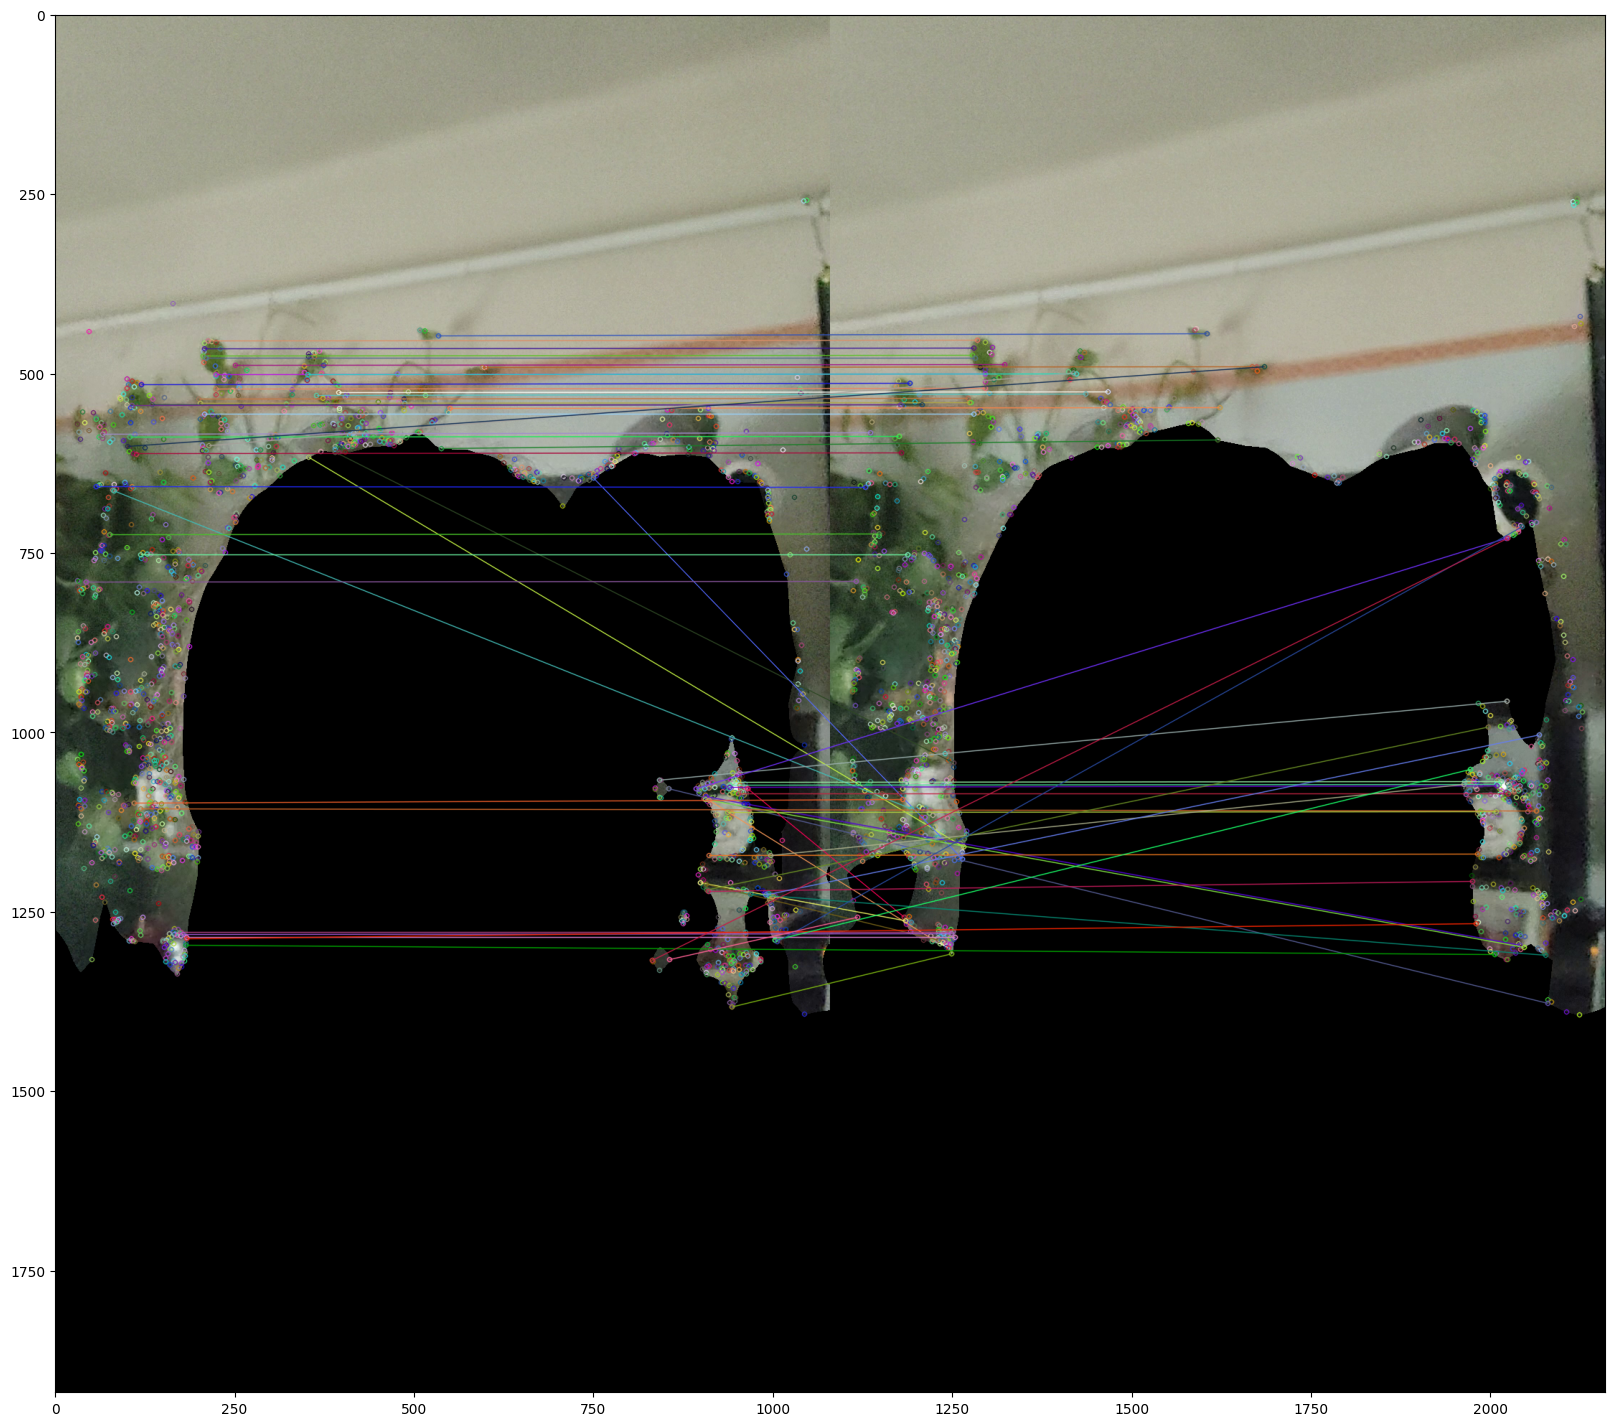

In [68]:
# visualize the matches
match_image = cv2.drawMatches(images[0], keypoints[0], images[1], keypoints[1], matches[0], None)
plt.figure(figsize=(20, 20))
plt.imshow(match_image)
plt.show()

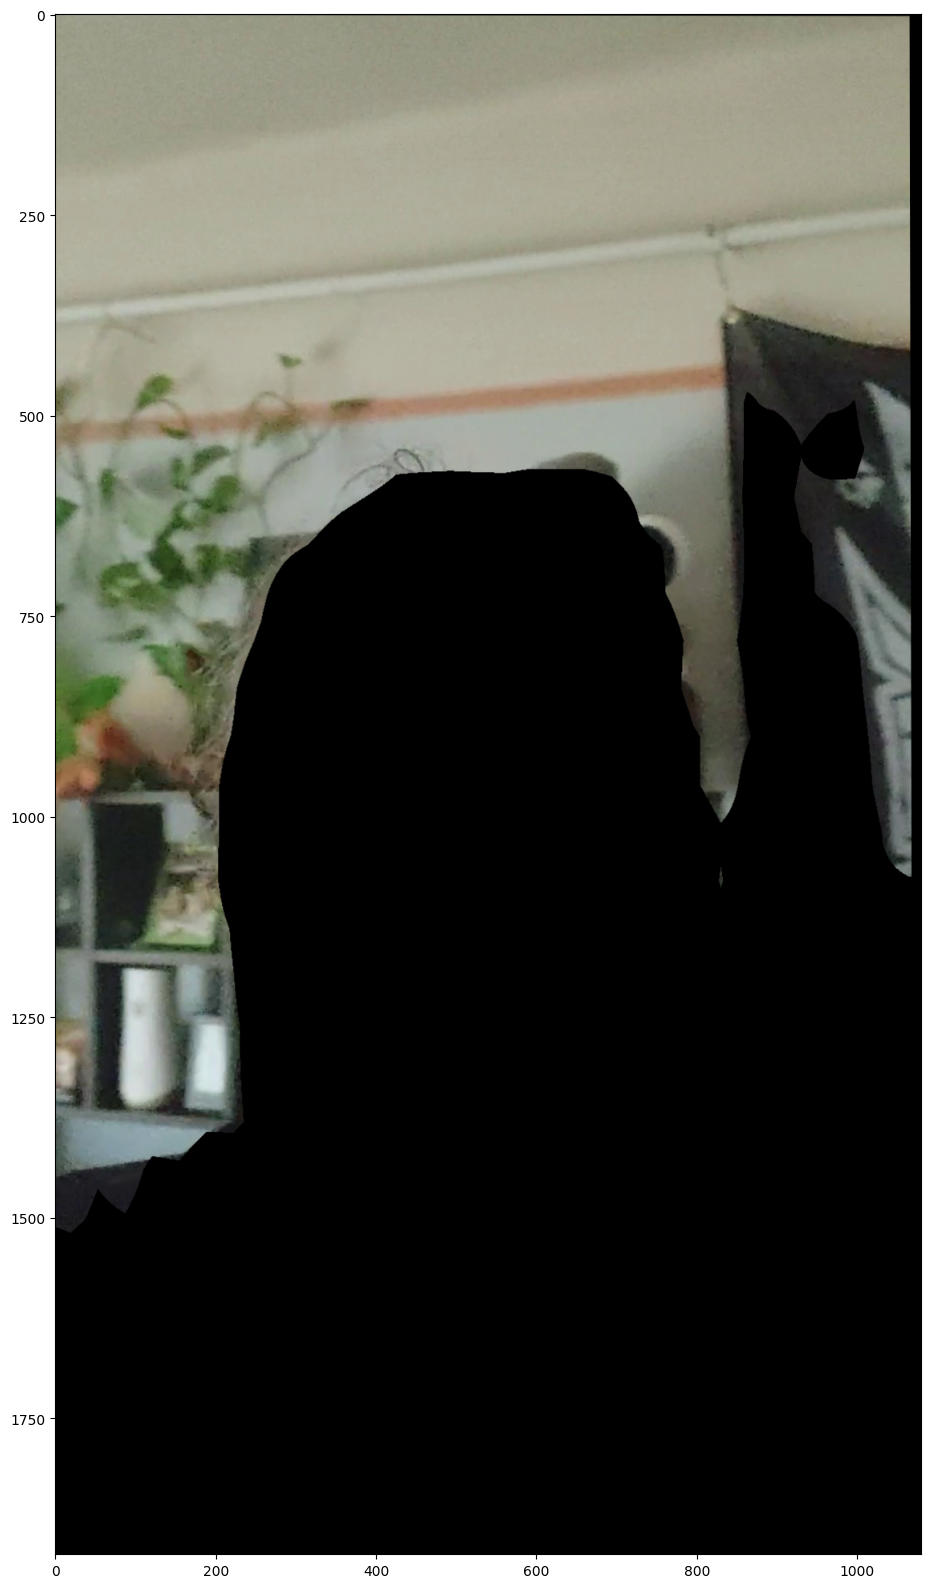

In [72]:
# Visualize warped images
plt.figure(figsize=(20, 20))
plt.imshow(warped_images[15])
plt.show()

In [75]:
homographies_first_base = []
for i in range(len(homographies)):
    if i == 0:
        homographies_first_base.append(homographies[i])
    else:
        homographies_first_base.append(homographies_first_base[i-1] @ homographies[i])

# Warp one image using the estimated homography matrix
warped_images_first_base = []
for i in range(len(images) - 1):
    warped_image = cv2.warpPerspective(images[i], homographies_first_base[i], (images[i+1].shape[1], images[i+1].shape[0]))
    warped_images_first_base.append(warped_image)

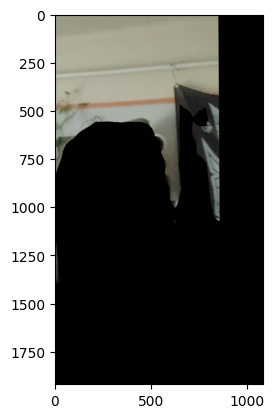

In [76]:
plt.imshow(warped_images_first_base[15])
plt.show()

In [77]:
from PIL import Image
gif_frames = [Image.fromarray(img) for img in warped_images_first_base]
gif_frames[0].save("warp.gif", save_all=True, append_images=gif_frames[1:], duration=50, loop=0)